# Antennal Lobe Demo
In this notebook, we go through the following examples.

1. Simulating Larva Antennal Lobe with affinity values inferred using `OlfTrans`
2. Change Number of PNs per channel
3. Change PN Parameter
4. Change Connectivity between OSN Axon Terminal and PN

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import typing as tp
import numpy as np
from itertools import product
from eoscircuits import al
import olftrans as olf
import olftrans.data
import olftrans.fbl
from olftrans.plot import plot_mat
from neurokernel.LPU.InputProcessors.StepInputProcessor import StepInputProcessor
import matplotlib.pyplot as plt
import typing as tp
import pandas as pd
import seaborn as sns

/mnt/server-home/tingkai/Project/FBL/olftrans/olftrans/olftrans.py:210: RuntimeWarning: invalid value encountered in power
  res = np.atleast_1d(np.power(c * (y - b) / (a - (y - b)), 1.0 / n))
/mnt/server-home/tingkai/Project/FBL/olftrans/olftrans/olftrans.py:210: RuntimeWarning: invalid value encountered in power
  res = np.atleast_1d(np.power(c * (y - b) / (a - (y - b)), 1.0 / n))


In [3]:
from eoscircuits.plot import plot_data, plot_spikes

## Setup

In [4]:
receptor_names = olf.fbl.LARVA.affinities.loc['ethyl acetate'].index.values.astype(str)
affinities = olf.fbl.LARVA.affinities.loc['ethyl acetate'].values

dt = 1e-5
dur = 4
steps = int((dur+dt/2)//dt)
t = np.arange(steps)*dt

# 1. Simulate Larva Antennal Lobe

In [5]:
cfg = al.ALConfig(
    affs=affinities, NP=1, NO=1,
    NPreLN=1, NPosteLN=1, NPostiLN=2,
    receptors=receptor_names,
    node_params=dict(
        osn_bsgs=dict(sigma=0.),
        osn_axts=dict(gamma=1.),
        postelns=dict(a2=0.012)
    )
)
al_circ = al.ALCircuit.create_from_config(cfg)

In [6]:
fi = StepInputProcessor('conc', al_circ.inputs['conc'], 100., start=1, stop=3)
fi, fo, lpu = al_circ.simulate(
    t, fi, 
    record_var_list=[
        (
            'I', 
            sum(al_circ.config.osn_otps,[]) + sum(al_circ.config.osn_axts,[]) + sum(al_circ.config.postelns,[]) + sum(al_circ.config.postilns,[])
        ),
        ('r', sum(al_circ.config.pns,[])),
        ('g', sum(al_circ.config.osn_alphas,[])),
        ('spike_state', sum(al_circ.config.osn_bsgs, []))
    ])

OlfTrans: Number of Alpha: 11
OlfTrans: Number of PN: 11
OlfTrans: Number of NoisyConnorStevens: 11
OlfTrans: Number of OTP: 11
OlfTrans: Number of PostLN: 33
OlfTrans: Number of OSNAxt2: 11
OlfTrans: Number of PreLN: 1
OlfTrans: Number of Input: {'conc': 11}


OlfTrans:   0%|          | 504/400000 [00:00<02:37, 2531.62it/s]

Compilation of executable circuit completed in 0.9822039604187012 seconds


OlfTrans: 100%|██████████| 400000/400000 [01:51<00:00, 3592.20it/s]


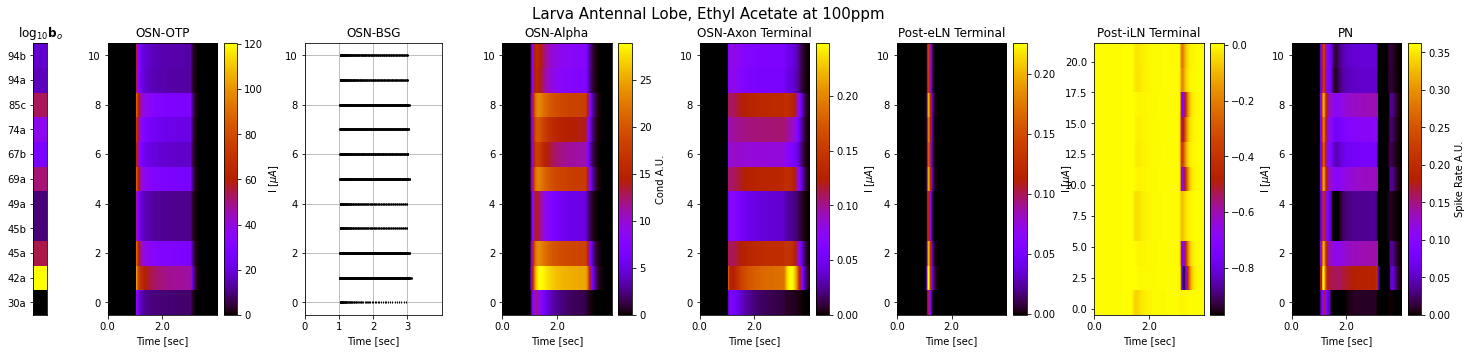

In [7]:
%matplotlib inline
otp_I = fo.get_output(var='I', uids=sum(al_circ.config.osn_otps,[]))
axt_I = fo.get_output(var='I', uids=sum(al_circ.config.osn_axts,[]))
eln_I = fo.get_output(var='I', uids=sum(al_circ.config.postelns,[]))
iln_I = fo.get_output(var='I', uids=sum(al_circ.config.postilns,[]))
bsg_spikes = fo.get_output(var='spike_state', uids=sum(al_circ.config.osn_bsgs,[]))
pn_r = fo.get_output(var='r')
alp_g = fo.get_output(var='g')

fig,axes = plt.subplots(1,8, figsize=(25,5), gridspec_kw={'width_ratios': [1]+[10]*7, 'wspace':.5})
axes[0].imshow(np.log10(al_circ.config.affs)[:,None], cmap=plt.cm.gnuplot, origin='lower', aspect='auto')
_ = plot_data(otp_I, t=t, ax=axes[1], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_spikes(bsg_spikes, ax=axes[2], markersize=2, color='k')
_ = plot_data(alp_g, t=t, ax=axes[3], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Cond A.U.'})
_ = plot_data(axt_I, t=t, ax=axes[4], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_data(eln_I, t=t, ax=axes[5], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_data(iln_I, t=t, ax=axes[6], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_data(pn_r, t=t, ax=axes[7], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Spike Rate A.U.'})

for ax in axes[1:]:
    ax.set_xlabel('Time [sec]')
axes[0].set_xticks([])
axes[0].set_title('$\log_{10}\mathbf{b}_o$')
axes[0].set_yticks(np.arange(al_circ.config.NR))
axes[0].set_yticklabels(al_circ.config.receptors)
axes[2].set_xlim([t.min(), t.max()])
axes[1].set_title('OSN-OTP')
axes[2].set_title('OSN-BSG')
axes[3].set_title('OSN-Alpha')
axes[4].set_title('OSN-Axon Terminal')
axes[5].set_title('Post-eLN Terminal')
axes[6].set_title('Post-iLN Terminal')
axes[7].set_title('PN')
axes[2].grid()
fig.suptitle('Larva Antennal Lobe, Ethyl Acetate at 100ppm', fontsize=15)
plt.show()

# 2. Change Number of PNs - 2 PNs per glomulus for given receptor type

In [8]:
# use 2 PNs for each receptor channel
al_circ = al_circ.set_neuron_number(node_type='pns', number=2)

In [9]:
fi = StepInputProcessor('conc', al_circ.inputs['conc'], 100., start=1, stop=3)
fi, fo, lpu = al_circ.simulate(
    t, fi, 
    record_var_list=[
        (
            'I', 
            sum(al_circ.config.osn_otps,[]) + sum(al_circ.config.osn_axts,[]) + sum(al_circ.config.postelns,[]) + sum(al_circ.config.postilns,[])
        ),
        ('r', sum(al_circ.config.pns,[])),
        ('g', sum(al_circ.config.osn_alphas,[])),
        ('spike_state', sum(al_circ.config.osn_bsgs, []))
    ])

OlfTrans: Number of Alpha: 11
OlfTrans: Number of PN: 22
OlfTrans: Number of NoisyConnorStevens: 11
OlfTrans: Number of OTP: 11
OlfTrans: Number of PostLN: 33
OlfTrans: Number of OSNAxt2: 11
OlfTrans: Number of PreLN: 1
OlfTrans: Number of Input: {'conc': 11}


OlfTrans:   0%|          | 700/400000 [00:00<01:54, 3501.67it/s]

Compilation of executable circuit completed in 0.941159725189209 seconds


OlfTrans: 100%|██████████| 400000/400000 [01:51<00:00, 3594.63it/s]


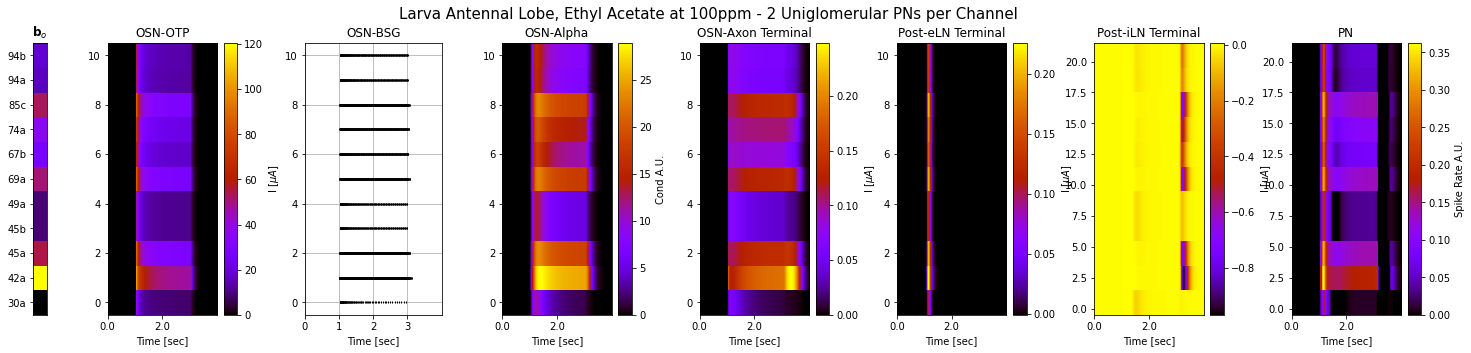

In [10]:
%matplotlib inline
otp_I = fo.get_output(var='I', uids=sum(al_circ.config.osn_otps,[]))
axt_I = fo.get_output(var='I', uids=sum(al_circ.config.osn_axts,[]))
eln_I = fo.get_output(var='I', uids=sum(al_circ.config.postelns,[]))
iln_I = fo.get_output(var='I', uids=sum(al_circ.config.postilns,[]))
bsg_spikes = fo.get_output(var='spike_state', uids=sum(al_circ.config.osn_bsgs,[]))
pn_r = fo.get_output(var='r')
alp_g = fo.get_output(var='g')

fig,axes = plt.subplots(1,8, figsize=(25,5), gridspec_kw={'width_ratios': [1]+[10]*7, 'wspace':.5})
axes[0].imshow(np.log10(al_circ.config.affs)[:,None], cmap=plt.cm.gnuplot, origin='lower', aspect='auto')

_ = plot_data(otp_I, t=t, ax=axes[1], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_spikes(bsg_spikes, ax=axes[2], markersize=2, color='k')
_ = plot_data(alp_g, t=t, ax=axes[3], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Cond A.U.'})
_ = plot_data(axt_I, t=t, ax=axes[4], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_data(eln_I, t=t, ax=axes[5], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_data(iln_I, t=t, ax=axes[6], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_data(pn_r, t=t, ax=axes[7], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Spike Rate A.U.'})

for ax in axes[1:]:
    ax.set_xlabel('Time [sec]')

axes[0].set_xticks([])
axes[0].set_title('$\mathbf{b}_o$')
axes[0].set_yticks(np.arange(al_circ.config.NR))
axes[0].set_yticklabels(al_circ.config.receptors)
axes[2].set_xlim([t.min(), t.max()])
axes[1].set_title('OSN-OTP')
axes[2].set_title('OSN-BSG')
axes[3].set_title('OSN-Alpha')
axes[4].set_title('OSN-Axon Terminal')
axes[5].set_title('Post-eLN Terminal')
axes[6].set_title('Post-iLN Terminal')
axes[7].set_title('PN')
axes[2].grid()
fig.suptitle('Larva Antennal Lobe, Ethyl Acetate at 100ppm - 2 Uniglomerular PNs per Channel', fontsize=15)
plt.show()

# 3. Change PN Parameter - set a higher spike rate threshold

In [11]:
al_circ.set_node_params(node_type='pns', key='threshold', value=.1)

In [12]:
fi = StepInputProcessor('conc', al_circ.inputs['conc'], 100., start=1, stop=3)
fi, fo, lpu = al_circ.simulate(
    t, fi, 
    record_var_list=[
        (
            'I', 
            sum(al_circ.config.osn_otps,[]) + sum(al_circ.config.osn_axts,[]) + sum(al_circ.config.postelns,[]) + sum(al_circ.config.postilns,[])
        ),
        ('r', sum(al_circ.config.pns,[])),
        ('g', sum(al_circ.config.osn_alphas,[])),
        ('spike_state', sum(al_circ.config.osn_bsgs, []))
    ])

OlfTrans: Number of Alpha: 11
OlfTrans: Number of PN: 22
OlfTrans: Number of NoisyConnorStevens: 11
OlfTrans: Number of OTP: 11
OlfTrans: Number of PostLN: 33
OlfTrans: Number of OSNAxt2: 11
OlfTrans: Number of PreLN: 1
OlfTrans: Number of Input: {'conc': 11}


OlfTrans:   0%|          | 688/400000 [00:00<01:55, 3446.63it/s]

Compilation of executable circuit completed in 0.950413703918457 seconds


OlfTrans: 100%|██████████| 400000/400000 [01:50<00:00, 3629.64it/s]


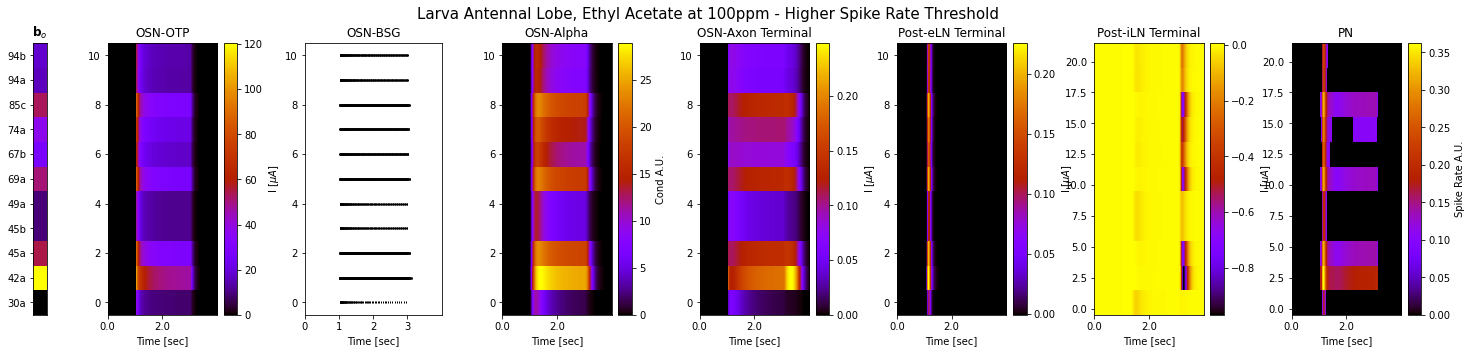

In [13]:
%matplotlib inline
otp_I = fo.get_output(var='I', uids=sum(al_circ.config.osn_otps,[]))
axt_I = fo.get_output(var='I', uids=sum(al_circ.config.osn_axts,[]))
eln_I = fo.get_output(var='I', uids=sum(al_circ.config.postelns,[]))
iln_I = fo.get_output(var='I', uids=sum(al_circ.config.postilns,[]))
bsg_spikes = fo.get_output(var='spike_state', uids=sum(al_circ.config.osn_bsgs,[]))

pn_r = fo.get_output(var='r')
alp_g = fo.get_output(var='g')


fig,axes = plt.subplots(1,8, figsize=(25,5), gridspec_kw={'width_ratios': [1]+[10]*7, 'wspace':.5})
axes[0].imshow(np.log10(al_circ.config.affs)[:,None], cmap=plt.cm.gnuplot, origin='lower', aspect='auto')
axes[0].set_xticks([])
axes[0].set_title('$\mathbf{b}_o$')

_ = plot_data(otp_I, t=t, ax=axes[1], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_spikes(bsg_spikes, ax=axes[2], markersize=2, color='k')

_ = plot_data(alp_g, t=t, ax=axes[3], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Cond A.U.'})
_ = plot_data(axt_I, t=t, ax=axes[4], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_data(eln_I, t=t, ax=axes[5], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_data(iln_I, t=t, ax=axes[6], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_data(pn_r, t=t, ax=axes[7], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Spike Rate A.U.'})

axes[0].set_yticks(np.arange(al_circ.config.NR))
axes[0].set_yticklabels(al_circ.config.receptors)
axes[2].set_xlim([t.min(), t.max()])
axes[1].set_title('OSN-OTP')
axes[2].set_title('OSN-BSG')
axes[3].set_title('OSN-Alpha')
axes[4].set_title('OSN-Axon Terminal')
axes[5].set_title('Post-eLN Terminal')
axes[6].set_title('Post-iLN Terminal')
axes[7].set_title('PN')
axes[2].grid()

for ax in axes[1:]:
    ax.set_xlabel('Time [sec]')

axes[2].set_xlim([t.min(), t.max()])
axes[1].set_title('OSN-OTP')
axes[2].set_title('OSN-BSG')
axes[3].set_title('OSN-Alpha')
axes[4].set_title('OSN-Axon Terminal')
axes[5].set_title('Post-eLN Terminal')
axes[6].set_title('Post-iLN Terminal')
axes[7].set_title('PN')
axes[2].grid()
fig.suptitle('Larva Antennal Lobe, Ethyl Acetate at 100ppm - Higher Spike Rate Threshold', fontsize=15)
plt.show()

# 4. Change Axon-Terimnal to PN Routing - Ablate connection from 3 receptor channels to corresponding PNs

In [14]:
# disconnect axon terminal from pn in the first 3 receptor channels
al_circ = al_circ.set_routing([None, None, None], 'axt_to_pn', receptor=al_circ.config.receptors[:3])

In [15]:
fi = StepInputProcessor('conc', al_circ.inputs['conc'], 100., start=1, stop=3)
fi, fo, lpu = al_circ.simulate(
    t, fi, 
    record_var_list=[
        (
            'I', 
            sum(al_circ.config.osn_otps,[]) + sum(al_circ.config.osn_axts,[]) + sum(al_circ.config.postelns,[]) + sum(al_circ.config.postilns,[])
        ),
        ('r', sum(al_circ.config.pns,[])),
        ('g', sum(al_circ.config.osn_alphas,[])),
        ('spike_state', sum(al_circ.config.osn_bsgs, []))
    ])

OlfTrans: Number of Alpha: 11
OlfTrans: Number of PN: 22
OlfTrans: Number of NoisyConnorStevens: 11
OlfTrans: Number of OTP: 11
OlfTrans: Number of PostLN: 33
OlfTrans: Number of OSNAxt2: 11
OlfTrans: Number of PreLN: 1
OlfTrans: Number of Input: {'conc': 11}


OlfTrans:   0%|          | 696/400000 [00:00<01:54, 3499.75it/s]

Compilation of executable circuit completed in 0.9961409568786621 seconds


OlfTrans: 100%|██████████| 400000/400000 [01:52<00:00, 3544.96it/s]


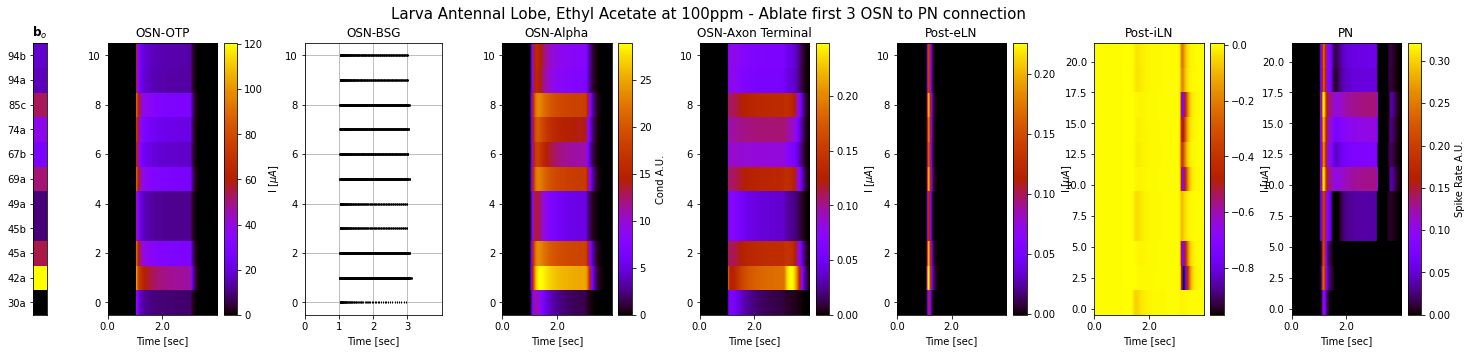

In [16]:
%matplotlib inline
otp_I = fo.get_output(var='I', uids=sum(al_circ.config.osn_otps,[]))
axt_I = fo.get_output(var='I', uids=sum(al_circ.config.osn_axts,[]))
eln_I = fo.get_output(var='I', uids=sum(al_circ.config.postelns,[]))
iln_I = fo.get_output(var='I', uids=sum(al_circ.config.postilns,[]))
bsg_spikes = fo.get_output(var='spike_state', uids=sum(al_circ.config.osn_bsgs,[]))

pn_r = fo.get_output(var='r')
alp_g = fo.get_output(var='g')


fig,axes = plt.subplots(1,8, figsize=(25,5), gridspec_kw={'width_ratios': [1]+[10]*7, 'wspace':.5})
axes[0].imshow(np.log10(al_circ.config.affs)[:,None], cmap=plt.cm.gnuplot, origin='lower', aspect='auto')
axes[0].set_xticks([])
axes[0].set_title('$\mathbf{b}_o$')

_ = plot_data(otp_I, t=t, ax=axes[1], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_spikes(bsg_spikes, ax=axes[2], markersize=2, color='k')
_ = plot_data(alp_g, t=t, ax=axes[3], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Cond A.U.'})
_ = plot_data(axt_I, t=t, ax=axes[4], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_data(eln_I, t=t, ax=axes[5], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_data(iln_I, t=t, ax=axes[6], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'I [$\mu A$]'})
_ = plot_data(pn_r, t=t, ax=axes[7], cmap=plt.cm.gnuplot, cax=True, cbar_kw={'label': 'Spike Rate A.U.'})

for ax in axes[1:]:
    ax.set_xlabel('Time [sec]')

axes[0].set_yticks(np.arange(al_circ.config.NR))
axes[0].set_yticklabels(al_circ.config.receptors)
axes[2].set_xlim([t.min(), t.max()])
axes[1].set_title('OSN-OTP')
axes[2].set_title('OSN-BSG')
axes[3].set_title('OSN-Alpha')
axes[4].set_title('OSN-Axon Terminal')
axes[5].set_title('Post-eLN')
axes[6].set_title('Post-iLN')
axes[7].set_title('PN')
axes[2].grid()
fig.suptitle('Larva Antennal Lobe, Ethyl Acetate at 100ppm - Ablate first 3 OSN to PN connection', fontsize=15)
plt.show()